# test inference pipeline on true noiseless $(M_{\rm UV}, z)$ 
- this tests the selection function

In [1]:
import os
import numpy as np 
from astropy import units as u
from astropy.cosmology import Planck13

In [2]:
import emcee

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read true $(M_{\rm UV}, z)$

In [4]:
mock_ztrue, mock_Muvtrue, mock_photoz, mock_Muv, mock_photoz_1sig, mock_Muv_1sig = np.loadtxt('/Users/chahah/data/binsin/mock0.dat',unpack=True, skiprows=1)

(-14.0, -22.0)

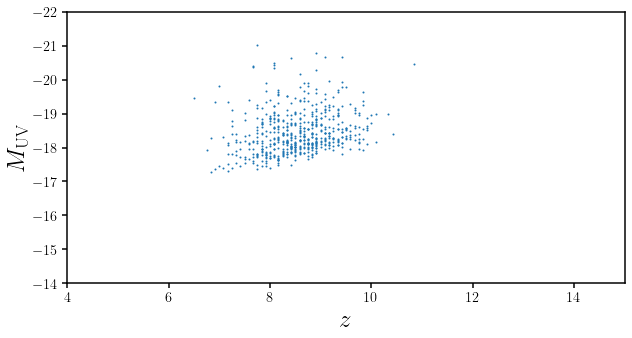

In [5]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.scatter(mock_ztrue, mock_Muvtrue, s=1)
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

In [6]:
n_mcmc = 100
posteriors = np.zeros((len(mock_ztrue), 2, n_mcmc))
posteriors[:,0,:] = mock_ztrue[:,None] + 0.01 * np.random.normal(size=(len(mock_ztrue), n_mcmc))
posteriors[:,1,:] = mock_Muvtrue[:,None] + 0.01 * np.random.normal(size=(len(mock_ztrue), n_mcmc))

# set up selection function 

In [7]:
S_z, S_Muv, S = np.loadtxt('/Users/chahah/data/binsin/mock0_selection.dat', skiprows=1, unpack=True)
S = S.astype(bool)

In [8]:
h, bx, by = np.histogram2d(S_z, S_Muv, bins=[60, 50], range=[(3.99, 15.01), (-22.01, -14.99)])
h_select, _, _ = np.histogram2d(S_z[S], S_Muv[S], bins=[60, 50], range=[(3.99, 15.01), (-22.01, -14.99)])

In [9]:
def p_theta_S(Muv, z): 
    i_x = np.digitize(Muv, by)
    i_y = np.digitize(z, bx)
    return (h_select/h).T[i_x-1, i_y-1]

(-15.0, -22.0)

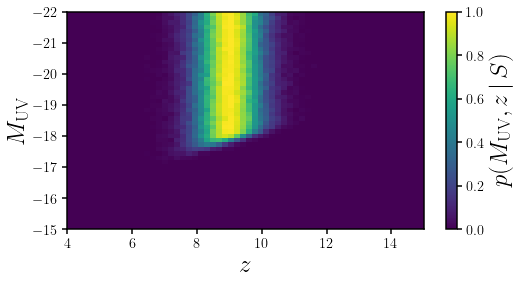

In [10]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
X, Y = np.meshgrid(bx, by)

p = sub.pcolormesh(X, Y, (h_select/h).T, vmin=0., vmax=1)

plt.colorbar(p).set_label(r'$p(M_{\rm UV}, z\,|\,S)$', size=25)
sub.set_xlabel('$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_ylim(-15, -22)

# set up  posterior
$$p(\phi\,|\,\{X_i\},S) \approx p(\phi\,|\,S) \prod\limits_{i=1}^{N} \frac{p(\theta_{i}\,|\,\phi, S)}{p(\theta_{i}\,|\,S)}$$
$$\log p(\phi\,|\,\{X_i\},S) \approx {\rm constant} + \log p(\phi\,|\,S) + \sum\limits_{i=1}^{N} \log \frac{\Phi(\theta_{i};\phi)/\int\Phi(\theta';\phi) S(\theta'){\rm d}\theta'}{p(\theta_{i}\,|\,S)}$$

In [11]:
def LF(Muv, z, phi): 
    #Muv_s = -19.5
    alpha, beta, gamma, Muv_s = phi
    return (10**(gamma * (z - 9.)))/(10**(0.4*(alpha + 1)*(Muv - Muv_s) + 10**(0.4*(beta + 1)*(Muv - Muv_s))))

In [16]:
unif = np.array([4., -22])[None,:] + np.array([10, 7])[None,:] * np.random.uniform(size=(100000, 2))
unif_S = p_theta_S(unif[:,1], unif[:,0])
mock_S = p_theta_S(mock_Muvtrue, mock_ztrue)
mock_Smask = np.ones(mock_S.shape)
mock_Smask[mock_S < 1e-5] = 0.
mock_S = mock_S.clip(1e-5, None)

In [38]:
def log_prior(phi): 
    alpha, beta, gamma, Muv_s = phi
    if -3. < alpha < 1. and -3. < beta < 1. and -1. < gamma < 1 and -22 < Muv_s < -15: 
        return 0.
    return -np.inf

def log_posterior(phi): 
    lp = log_prior(phi)
    if not np.isfinite(lp):
        return -np.inf
    
    #Phi = LF(posteriors[:,1,:], posteriors[:,0,:], phi)
    Phi = LF(mock_Muvtrue, mock_ztrue, phi)
    norm_Phi = np.sum(LF(unif[:,1], unif[:,0], phi) * unif_S)
    Phi /= norm_Phi

    #logp = np.sum(np.log(np.sum(Phi, axis=1)), axis=0)
    logp = np.sum(np.log(Phi / mock_S) * mock_Smask)
    if np.isnan(logp): raise ValueError
    return logp

In [40]:
log_posterior([-1.5,  -1.33, -0.2, -17.98954929]), log_posterior([-1.21126749, -1.39672104, -0.14763412, -19.5]), log_posterior([-0.001, -1.45, -0.05, -20]), log_posterior([-2.99, -2.8, -0.98, -19])

(-4100.321102022406,
 -4133.974596866374,
 -4663.754120020185,
 -5527.0459426716625)

In [41]:
ndim, nwalkers = 4, 20
var = np.array([0.1, 0.1, 0.1, 0.1])
p0 = np.array([-1.2, -1.4, -0.15, -19.4])[None,:] + var[None,:]*np.random.randn(nwalkers, ndim)

In [46]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
_ = sampler.run_mcmc(p0, 2000, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:27<00:00,  7.47it/s]


In [53]:
_ = sampler.run_mcmc(sampler.get_chain()[-1,:,:], 2000, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:10<00:00,  7.99it/s]


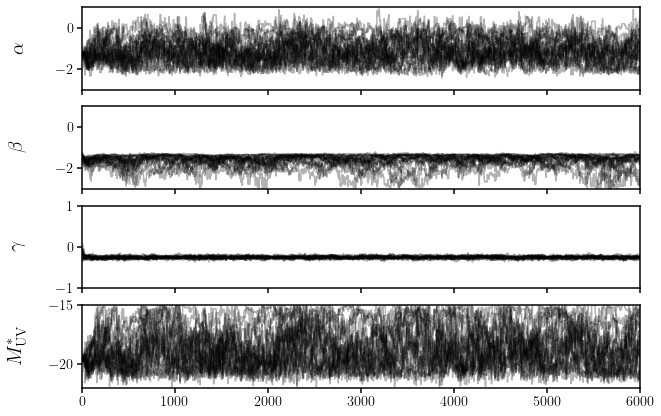

In [54]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel([r'$\alpha$', r'$\beta$', r'$\gamma$', r'$M_{\rm UV}^*$'][i], fontsize=20)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylim([(-3., 1.), (-3., 1.), (-1., 1.), (-22, -15)][i])

In [44]:
from binsin import lf as bLF

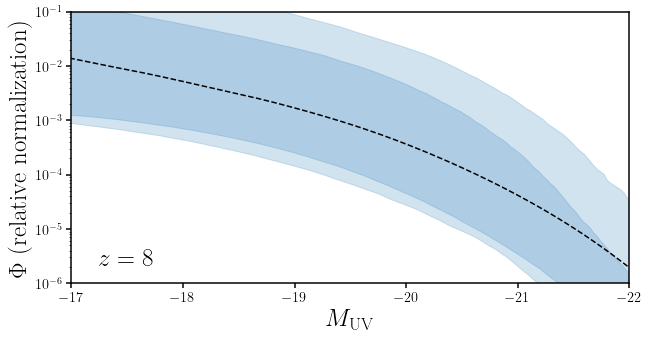

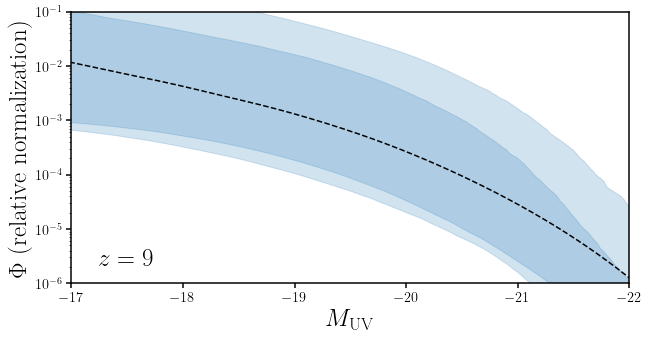

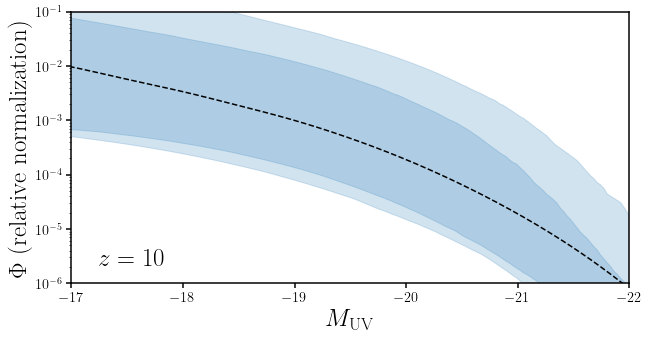

In [55]:
for z in [8.5, 9, 9.5]: 
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)

    muv, lf = bLF.lf_zeus21(z)
    
    lfs = []
    for phi in sampler.flatchain[nwalkers*-200:,:]:
        lfs.append(LF(muv, z, phi))

    phi_med = np.median(sampler.flatchain[nwalkers*-100:,:], axis=0)
    
    #norm = np.sum(LF(unif[:,1], unif[:,0], phi_med) * unif_S)
    #f = lambda y, x: LF(x, y, phi_med) * p_theta_S(x, y)
    #norm = integrate.dblquad(f, -22, -16, 4, 15)
    #print(1/(float(len(mock_Muv))/norm))

    q0, q1, q2, q3 = np.quantile(1e-2*np.array(lfs), [0.025, 0.16, 0.84, 0.975], axis=0)

    sub.fill_between(muv, q0, q3, color='C0', alpha=0.2)
    sub.fill_between(muv, q1, q2, color='C0', alpha=0.2)
    sub.plot(muv, lf, c='k', ls='--')
    
    sub.text(0.05, 0.05, r'$z=%.f$' % z, fontsize=25, transform=sub.transAxes, ha='left', va='bottom')
    sub.set_xlabel(r'$M_{\rm UV}$', fontsize=25)
    sub.set_xlim(-17, -22)
    sub.set_ylabel(r'$\Phi$ (relative normalization)', fontsize=25)
    sub.set_yscale('log')
    sub.set_ylim(1e-6, 1e-1)#sub.set_ylim(0.1, 4e2)
    #sub.set_ylim(0.1, 4e2)